In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1440
[0.16312509029104827, 0.09636490446440792, 0.03636643773183382, 0.21849298240279427, 0.03651675631669997, 0.019132423710002903, 0.05933243108388687, 0.12247264926103713, 0.6385500001324462, 0.2022302569658592, 0.07471903553293849, 0.16814292142663018, 0.0230523225129767, 0.1609042880961581, 0.2688387764755287, 0.05549755459546917, 0.012694034520736917, 0.09389877662294215, 0.024808470564410257, 0.012916016567435117, 0.537538199511473, 0.10166459547430746, 0.017003778368234634, 0.1895631651814792, 0.011007644292289143, 0.1908368021249771, 0.16246922314167023, 0.09223736189469771, 0.08370963329421344, 0.5588908545309716, 0.03431704460795354, 0.045772770042914156, 0.15501195511789118, 0.026778635366288318, 0.02533061849344048, 0.044663360767730004, 0.05472224588958281, 0.028879488831018898, 0.1309257580510967, 0.11610612932071074, 0.7052331632631441, 0.42965823402192654, 0.09028542237526906, 0.08645685263723765, 0.6922198305107939, 0.5510788138832429, 0.014685248829668424, 0.02854885

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

Isochrone generation took 1.667461 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.00  dist = 410
     Starting at:  2023-12-19 16:18:15.902894   Usually takes ~5 minutes
Starting filter: jwst,F115W   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2898 K  m_jwst_F115W = 14.53
Starting filter: jwst,F182M   Elapsed time: 0.60 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2898 K  m_jwst_F182M = 13.80
      Time taken: 1.02 seconds
Isochrone generation took 0.899855 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.00  dist = 410
     Starting at:  2023-12-19 16:18:17.847111   Usually takes ~5 minutes
Starting filter: jwst,F115W   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2901 K  m_jwst_F115W = 14.59
Starting filter: jwst,F182M   Elapsed time: 0.42 seconds
Starting synthetic photometry
M =   0.070 Msun  T =  2901 K  m_jwst_F182M = 13.85
      Time taken: 0.83 seconds
Isochrone generati

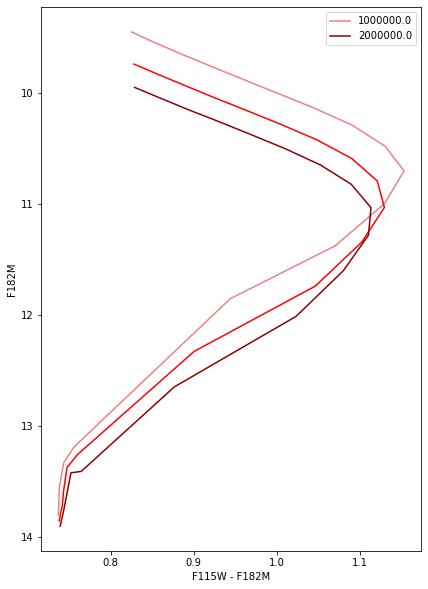

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 56.24521950614411 is outside the range of the isochrone.
Desired mass 56.24521950614411 is outside the range of the isochrone.
Desired mass 12.96283688892593 is outside the range of the isochrone.
Desired mass 12.96283688892593 is outside the range of the isochrone.
Desired mass 14.494145017213652 is outside the range of the isochrone.
Desired mass 14.494145017213652 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 7.626421404264792 is outside the range of the isochrone.
Desired mass 7.626421404264792 is outside the range of the isochrone.
Desired mass 0.06854727299807327 is outside the range of the isochrone.
Desired mass 0.06854727299807327 is outside the range of the isochrone.
Desired mass 0.06595964158779352 is outside the range of the isochrone.
Desired mass 0.06595964158779352 is outside the range of the isochrone.
Desired 

Desired mass 0.043405169937818656 is outside the range of the isochrone.
Desired mass 0.043405169937818656 is outside the range of the isochrone.
Desired mass 0.027155654945961647 is outside the range of the isochrone.
Desired mass 0.027155654945961647 is outside the range of the isochrone.
Desired mass 0.04305133860815552 is outside the range of the isochrone.
Desired mass 0.04305133860815552 is outside the range of the isochrone.
Desired mass 0.06430425494909286 is outside the range of the isochrone.
Desired mass 0.06430425494909286 is outside the range of the isochrone.
Desired mass 0.04993591085076332 is outside the range of the isochrone.
Desired mass 0.04993591085076332 is outside the range of the isochrone.
Desired mass 0.029854124575104387 is outside the range of the isochrone.
Desired mass 0.029854124575104387 is outside the range of the isochrone.
Desired mass 0.03321996433615414 is outside the range of the isochrone.
Desired mass 0.03321996433615414 is outside the range of t

Desired mass 0.054928203638040365 is outside the range of the isochrone.
Desired mass 0.054928203638040365 is outside the range of the isochrone.
Desired mass 0.020009032647517896 is outside the range of the isochrone.
Desired mass 0.020009032647517896 is outside the range of the isochrone.
Desired mass 0.014163223822140176 is outside the range of the isochrone.
Desired mass 0.014163223822140176 is outside the range of the isochrone.
Desired mass 0.06346404548451078 is outside the range of the isochrone.
Desired mass 0.06346404548451078 is outside the range of the isochrone.
Desired mass 0.05199072490728678 is outside the range of the isochrone.
Desired mass 0.05199072490728678 is outside the range of the isochrone.
Desired mass 0.05176971246249023 is outside the range of the isochrone.
Desired mass 0.05176971246249023 is outside the range of the isochrone.
Desired mass 0.06860887909384694 is outside the range of the isochrone.
Desired mass 0.06860887909384694 is outside the range of t

Desired mass 2.1865030285859386 is outside the range of the isochrone.
Desired mass 2.1865030285859386 is outside the range of the isochrone.
Desired mass 0.052481869168213686 is outside the range of the isochrone.
Desired mass 0.052481869168213686 is outside the range of the isochrone.
Desired mass 0.04729007038910324 is outside the range of the isochrone.
Desired mass 0.04729007038910324 is outside the range of the isochrone.
Desired mass 0.04511058854231866 is outside the range of the isochrone.
Desired mass 0.04511058854231866 is outside the range of the isochrone.
Desired mass 0.022508114054041534 is outside the range of the isochrone.
Desired mass 0.022508114054041534 is outside the range of the isochrone.
Desired mass 0.020262515172362328 is outside the range of the isochrone.
Desired mass 0.020262515172362328 is outside the range of the isochrone.
Desired mass 0.0456426126821919 is outside the range of the isochrone.
Desired mass 0.0456426126821919 is outside the range of the i

Desired mass 0.05326009419276776 is outside the range of the isochrone.
Desired mass 0.05326009419276776 is outside the range of the isochrone.
Desired mass 0.02512364407521134 is outside the range of the isochrone.
Desired mass 0.02512364407521134 is outside the range of the isochrone.
Desired mass 0.05676473086611732 is outside the range of the isochrone.
Desired mass 0.05676473086611732 is outside the range of the isochrone.
Desired mass 0.0277422757063397 is outside the range of the isochrone.
Desired mass 0.0277422757063397 is outside the range of the isochrone.
Desired mass 0.06403017555090666 is outside the range of the isochrone.
Desired mass 0.06403017555090666 is outside the range of the isochrone.
Desired mass 0.03210343563844096 is outside the range of the isochrone.
Desired mass 0.03210343563844096 is outside the range of the isochrone.
Desired mass 0.037686172536866736 is outside the range of the isochrone.
Desired mass 0.037686172536866736 is outside the range of the iso

Desired mass 0.06860835620280212 is outside the range of the isochrone.
Desired mass 0.06860835620280212 is outside the range of the isochrone.
Desired mass 0.026546610585459568 is outside the range of the isochrone.
Desired mass 0.026546610585459568 is outside the range of the isochrone.
Desired mass 0.033063715888196545 is outside the range of the isochrone.
Desired mass 0.033063715888196545 is outside the range of the isochrone.
Desired mass 0.05523015892133379 is outside the range of the isochrone.
Desired mass 0.05523015892133379 is outside the range of the isochrone.
Desired mass 0.051179405445497206 is outside the range of the isochrone.
Desired mass 0.051179405445497206 is outside the range of the isochrone.
Desired mass 0.04065730229740655 is outside the range of the isochrone.
Desired mass 0.04065730229740655 is outside the range of the isochrone.
Desired mass 2.0690722474728847 is outside the range of the isochrone.
Desired mass 2.0690722474728847 is outside the range of the

Desired mass 0.01101603187550404 is outside the range of the isochrone.
Desired mass 0.01101603187550404 is outside the range of the isochrone.
Desired mass 0.053452580214615464 is outside the range of the isochrone.
Desired mass 0.053452580214615464 is outside the range of the isochrone.
Desired mass 0.03914312586345561 is outside the range of the isochrone.
Desired mass 0.03914312586345561 is outside the range of the isochrone.
Desired mass 0.03708903570845044 is outside the range of the isochrone.
Desired mass 0.03708903570845044 is outside the range of the isochrone.
Desired mass 0.0503911784070587 is outside the range of the isochrone.
Desired mass 0.0503911784070587 is outside the range of the isochrone.
Desired mass 0.03437088424202226 is outside the range of the isochrone.
Desired mass 0.03437088424202226 is outside the range of the isochrone.
Desired mass 0.052865058908607473 is outside the range of the isochrone.
Desired mass 0.052865058908607473 is outside the range of the i

Desired mass 6.907960328915318 is outside the range of the isochrone.
Desired mass 6.907960328915318 is outside the range of the isochrone.
Desired mass 1.468153953552246 is outside the range of the isochrone.
Desired mass 1.468153953552246 is outside the range of the isochrone.
Desired mass 14.595396495079344 is outside the range of the isochrone.
Desired mass 14.595396495079344 is outside the range of the isochrone.
Desired mass 0.02651828889262121 is outside the range of the isochrone.
Desired mass 0.02651828889262121 is outside the range of the isochrone.
Desired mass 0.02193192754386595 is outside the range of the isochrone.
Desired mass 0.02193192754386595 is outside the range of the isochrone.
Desired mass 0.03171579104886849 is outside the range of the isochrone.
Desired mass 0.03171579104886849 is outside the range of the isochrone.
Desired mass 0.037132495925361914 is outside the range of the isochrone.
Desired mass 0.037132495925361914 is outside the range of the isochrone.


[0.7288347378704546, 3998.155, 3.753, 11.782, 10.677]
[0.5926095505981243, 3889.507, 3.736, 11.976, 10.853]
[0.06148356637737119, 2947.01, 3.469, 14.033, 13.275]
[0.18896515602656658, 3322.369, 3.599, 13.007, 12.034]
[0.5072503310889791, 3809.216, 3.725, 12.12, 10.992]
None
None
None
[0.06579984274966491, 2963.946, 3.477, 13.981, 13.216]
[0.2933214482977483, 3527.459, 3.659, 12.611, 11.537]
[0.11321721743586867, 3119.507, 3.532, 13.512, 12.663]
[0.05751908542686884, 2926.179, 3.458, 14.101, 13.351]
[1.574704940009757, 4411.069, 3.798, 11.022, 10.083]
[0.04643373059139002, 2913.609, 3.484, 14.331, 13.588]
[0.09362650204007686, 3057.451, 3.512, 13.707, 12.891]
None
[0.06259194993607337, 2955.032, 3.476, 14.015, 13.255]
[0.5902330015907749, 3889.651, 3.739, 11.981, 10.858]
None
None
None
[0.1974310368837411, 3345.106, 3.61, 12.969, 11.982]
[0.05160383681317604, 2916.919, 3.468, 14.222, 13.476]
[0.30915272842704145, 3556.777, 3.669, 12.564, 11.482]
[0.06189310469776972, 2950.868, 3.473, 14

None
[0.5787078912380155, 3874.304, 3.732, 12.0, 10.875]
[0.038396540662770415, 2904.765, 3.514, 14.537, 13.798]
None
[0.7304915600651063, 3997.982, 3.752, 11.78, 10.675]
[0.1290604277669534, 3169.769, 3.548, 13.358, 12.481]
[1.1662223939153271, 4252.911, 3.783, 11.319, 10.307]
[0.0415107612194476, 2911.646, 3.502, 14.453, 13.711]
None
[0.16574249889172732, 3271.487, 3.587, 13.118, 12.18]
None
None
[0.06578566711095252, 2963.548, 3.476, 13.981, 13.216]
None
[0.0927434802778412, 3051.396, 3.507, 13.715, 12.903]
[0.06172807291943917, 2948.023, 3.469, 14.028, 13.27]
[0.10736205283354482, 3102.075, 3.528, 13.57, 12.731]
[0.06478074988850256, 2962.001, 3.478, 13.993, 13.229]
[0.16114727561445102, 3261.241, 3.584, 13.14, 12.21]
[0.18026467315883848, 3305.533, 3.598, 13.05, 12.09]
None
None
[0.1351520669265015, 3189.577, 3.555, 13.298, 12.411]
None
None
[0.6509869922965432, 3940.878, 3.744, 11.886, 10.768]
[0.09492577625551932, 3058.48, 3.509, 13.694, 12.878]
[0.11327050386713601, 3122.316, 3

In [10]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    print(companions[i])

Desired mass 0.05933243108388687 is outside the range of the isochrone.
Desired mass 0.05933243108388687 is outside the range of the isochrone.
Desired mass 0.0230523225129767 is outside the range of the isochrone.
Desired mass 0.0230523225129767 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.024808470564410257 is outside the range of the isochrone.
Desired mass 0.024808470564410257 is outside the range of the isochrone.
Desired mass 0.044663360767730004 is outside the range of the isochrone.
Desired mass 0.044663360767730004 is outside the range of the isochrone.
Desired mass 0.028879488831018898 is outside the range of the isochrone.
Desired mass 0.028879488831018898 is outside the range of the isochrone.
Desired mass 0.02854885506642551 is outside the range of the isochrone.
Desired mass 0.02854885506642551 is outside the range of the

Desired mass 0.04425639684320039 is outside the range of the isochrone.
Desired mass 0.04425639684320039 is outside the range of the isochrone.
Desired mass 0.05559412950135758 is outside the range of the isochrone.
Desired mass 0.05559412950135758 is outside the range of the isochrone.
Desired mass 0.06646527379724082 is outside the range of the isochrone.
Desired mass 0.06646527379724082 is outside the range of the isochrone.
Desired mass 0.056186752418451426 is outside the range of the isochrone.
Desired mass 0.056186752418451426 is outside the range of the isochrone.
Desired mass 0.05598197483695271 is outside the range of the isochrone.
Desired mass 0.05598197483695271 is outside the range of the isochrone.
Desired mass 0.06108314259229205 is outside the range of the isochrone.
Desired mass 0.06108314259229205 is outside the range of the isochrone.
Desired mass 0.032316119384432324 is outside the range of the isochrone.
Desired mass 0.032316119384432324 is outside the range of the

Desired mass 0.05469968249004712 is outside the range of the isochrone.
Desired mass 0.05469968249004712 is outside the range of the isochrone.
Desired mass 0.039013212088727704 is outside the range of the isochrone.
Desired mass 0.039013212088727704 is outside the range of the isochrone.
Desired mass 0.0450021362453176 is outside the range of the isochrone.
Desired mass 0.0450021362453176 is outside the range of the isochrone.
Desired mass 0.04480579121837391 is outside the range of the isochrone.
Desired mass 0.04480579121837391 is outside the range of the isochrone.
Desired mass 0.058252477511055716 is outside the range of the isochrone.
Desired mass 0.058252477511055716 is outside the range of the isochrone.
Desired mass 0.060526154661133556 is outside the range of the isochrone.
Desired mass 0.060526154661133556 is outside the range of the isochrone.
Desired mass 0.06039501355105195 is outside the range of the isochrone.
Desired mass 0.06039501355105195 is outside the range of the

[0.10205187365651533, 3082.95, 3.519, 13.623, 12.793]
[0.057303386849808284, 2923.479, 3.455, 14.104, 13.356]
[0.04429490772383264, 2912.484, 3.491, 14.384, 13.641]
[0.19432005560893326, 3331.527, 3.599, 12.981, 12.002]
[0.08949541891320284, 3041.712, 3.504, 13.747, 12.94]
[0.15608648601195102, 3246.684, 3.575, 13.16, 12.239]
[0.11478721431735829, 3124.64, 3.533, 13.497, 12.645]
[0.04599425146240935, 2912.924, 3.485, 14.342, 13.599]
[0.361349554475495, 3635.858, 3.687, 12.416, 11.311]
[0.04165531593187203, 2911.982, 3.502, 14.449, 13.707]
[0.791994401494483, 4043.501, 3.758, 11.697, 10.603]
[0.08155124858787358, 3015.59, 3.495, 13.825, 13.032]
[0.30588998780335164, 3548.464, 3.664, 12.573, 11.492]
[0.4704884854218575, 3766.74, 3.713, 12.183, 11.055]
[0.4357604585235015, 3725.073, 3.704, 12.257, 11.137]
[0.2866090419428443, 3516.057, 3.656, 12.632, 11.56]
[0.14021500245203403, 3207.881, 3.563, 13.245, 12.349]
[0.12439736584315844, 3153.342, 3.541, 13.405, 12.537]
[0.05842374625885317, 2

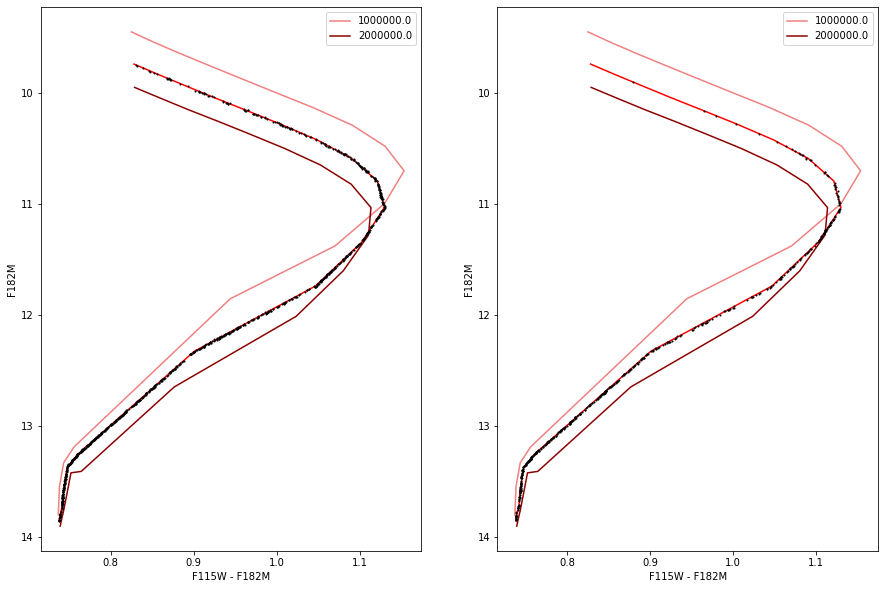

In [11]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [12]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

for i in range(len(unresolved_binaries)):
    print(unresolved_binaries[i])

[12.202315584711048, 11.18692175761122]
[12.819504558183715, 11.964608095899749]
None
[11.817484167967788, 10.745380422878743]
None
None
None
[13.02188976148701, 12.218089658833474]
[10.39836410255586, 9.46122561210699]
[11.939286747532423, 10.886496474771349]
[13.408920868450313, 12.645069552167403]
[12.673349768434967, 11.807233963576733]
None
[12.36387010946741, 11.385156237809193]
[11.948645955981457, 10.892520134560968]
None
None
[12.808899943387928, 11.94764856433811]
None
None
[10.81559900549314, 9.782419267849344]
[12.663521678666253, 11.75266840928014]
None
[12.0019434317686, 10.955591082163792]
None
[12.259401284730258, 11.270202385996054]
[12.699767233908375, 11.838240324543845]
[12.958436841846819, 12.133852623703925]
[12.948356405250504, 12.107601992495562]
None
None
None
[12.488500289610972, 11.55557717912439]
None
None
None
None
None
[12.831898887008567, 11.991241587291077]
[13.046331433688982, 12.247642195552267]
[10.818280300856966, 9.751943475622758]
[11.4876118335819

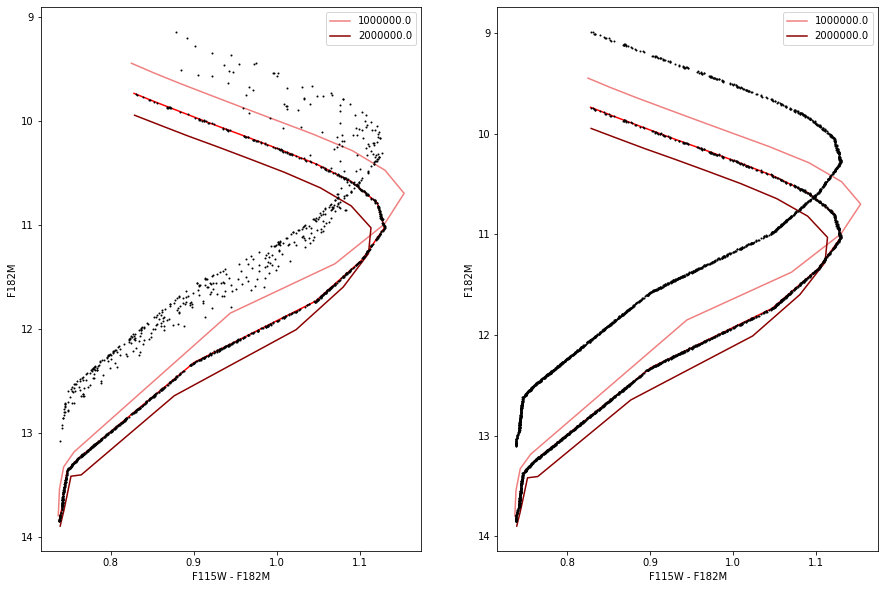

In [14]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='k')